# Loads

In [ ]:
!pip install seqeval -q
!pip install transformers[torch] -q
!pip install flair -q

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import re
import random
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from transformers import (
    RobertaTokenizer,
    BertTokenizerFast,
    pipeline
)

from flair.data import Sentence
from flair.models import SequenceTagger

from seqeval.metrics import f1_score, classification_report

#Functions

In [ ]:
#функция для извлечения пар токен-тег
def get_tokens_pairs(texts, tags, bio=True):

    res_tokens = []
    res_tags = []

    for text, text_tags in zip(texts, tags):
        result = [('[CLS]', 'O')]
        all_tokens = ['[CLS]']
        all_tags = ['O']

        for (word, tag) in zip(text, text_tags):
            tokens = tokenizer.tokenize(word)
            all_tokens.extend(tokens)

            if bio:
                if tag.startswith('B'):
                    all_tags.append(tag)
                    all_tags.extend([tag]*(len(tokens)-1))
                else:
                    all_tags.extend([tag]*len(tokens))
            else:
                if tag == 'O':
                    all_tags.extend([tag]*len(tokens))
                else:
                    all_tags.extend([tag[2:]]*len(tokens))

        all_tokens.append('[SEP]')
        all_tags.append('O')

        res_tokens.append(all_tokens)
        res_tags.append(all_tags)

    return res_tokens, res_tags

In [ ]:
#словари, переводящие тег в цифровое значение, и наоборот
tag2id = {'B-PERSON': 0, 'B-PLACE': 1, 'B-GROUP': 2, 'O': 3}

id2tag = {idx: tag for tag, idx in tag2id.items()}

# Data

In [ ]:
#считываем датасет
data = pd.read_csv('full_dataset.csv')

In [ ]:
#заменяем теги CITY, REGION, WATER на PLACE, а PROPERTY добавляем к PERSON
tags = []
for tag in data['tag']:
    if tag == 'CITY' or tag == 'REGION' or tag == 'WATER':
        new_tag = 'PLACE'
    elif tag == 'PROPERTY':
        new_tag = 'PERSON'
    else:
        new_tag = tag
    tags.append(new_tag)

In [ ]:
data['tag'] = tags
data

,lemma,tag,tokens,comment
0,Abel,PERSON,NaN,NaN
1,Adelger,PERSON,NaN,NaN
2,Albarle,PLACE,NaN,NaN
3,Alberich,PERSON,Albrich:Albriche:Albrichen:Albriches:Albrichæ,NaN
4,Albrant,PERSON,NaN,NaN
...,...,...,...,...
382,Ysolt,PERSON,NaN,NaN
383,Zazamanc,PLACE,Zazamanch,NaN
384,Zeiselmauer,PLACE,NaN,NaN
385,Zene,PERSON,NaN,NaN


In [ ]:
#список всех токенов в датасете
data_dict = data.to_dict('list')
tokens = []
for i in data_dict['tokens']:
    if type(i) != float:
        new_i = i.split(':')
        tokens.append(new_i)
    else:
        tokens.append([])
data_dict['tokens'] = tokens

In [ ]:
#тексты, входящие в цикл о Дитрихе
texts = ['/content/drive/MyDrive/4 курс/Диплом/тексты/Dietrich/Alpharts_Tod.txt',
         '/content/drive/MyDrive/4 курс/Диплом/тексты/Dietrich/Dietrich_und_Wenezlan.txt',
         '/content/drive/MyDrive/4 курс/Диплом/тексты/Dietrich/Dietrichs_Flucht.txt',
         '/content/drive/MyDrive/4 курс/Диплом/тексты/Dietrich/Rabenschlacht.txt',
         '/content/drive/MyDrive/4 курс/Диплом/тексты/Dietrich/Rosengarten_A.txt',
         '/content/drive/MyDrive/4 курс/Диплом/тексты/Dietrich/Der_Wunderer(Dresdener Heldenbuch).txt']

Следующие ячейки необходимо повторить для каждого текста.

In [ ]:
#считываем текст
with open('/content/drive/MyDrive/4 курс/Диплом/тексты/Dietrich/Der_Wunderer(Dresdener Heldenbuch).txt') as fi:
    text = fi.read()
    splitted_text = text.split('.')

In [ ]:
#разделение на предложения
text_dict = {'id': [], 'text': []}
for i in range(len(splitted_text)):
    clean_text = splitted_text[i].strip().replace("' ", '').replace("'", '').replace("^ ", '').replace("\n ", '') + '.'
    if re.search('[a-zA-Z]', clean_text):
        text_dict['id'].append(i)
        text_dict['text'].append(clean_text)

In [ ]:
#разделение знаков припенания
new_texts = []
for i in text_dict['text']:
    new_i = re.findall(r"[\w']+|[.,!?;]", i)
    new_sent = ' '.join(new_i)
    new_texts.append(new_sent)
text_dict['text'] = new_texts

In [ ]:
text_pd = pd.DataFrame.from_dict(text_dict)
text_pd

,id,text
0,0,Es sass in Ungerlande ein konick so wol bekant...
1,1,sein gleichen man nydert fant an reichtum vnd ...
2,2,zwelf konicklich kron vnd schilde dinten dem k...
3,3,"Er het zwelf konickreich freye , dye waren im ..."
4,4,der konig was milt vnd gerechte ; sein gleich ...
...,...,...
480,481,"Nun hot ein end das gedichte , wer es horet ho..."
481,482,nun seinn sie al sampt tot .
482,483,mit hert streitigem quelle gaben sie auf ir le...
483,484,"got alln gelaubigen selle , den sol got gnade ..."


In [ ]:
#два словаря: full_dict, в котором показано, какой именно токен встречается в предложении, а также дана его лемма и тег
#bio_data состоит из слова и его тега для всех предложений, id соответствует номеру предложения
full_dict = {'id': [], 'text': [], 'token': [], 'lemma': [], 'tag': []}
bio_data = {'id': [], 'bio_token': [], 'bio_tag': []}
id = 10961 #нужно обнавлять id, в зависимости от того, какой был последним сохранившимся
flag = False #оба флага показывают, записалось ли слово, то есть есть ли у него тег, если нет, то слову приписывается тег O
bio_flag = False #(один флаг для предложения, другой для конкретного слова)
for sentence in text_dict['text']:
    for word in sentence.split():
        for i in range(len(data_dict['lemma'])):
            for token in data_dict['tokens'][i]:
                if token == word:
                    full_dict['id'].append(id)
                    full_dict['text'].append(sentence)
                    full_dict['token'].append(token)
                    full_dict['lemma'].append(data_dict['lemma'][i])
                    full_dict['tag'].append(data_dict['tag'][i])

                    bio_data['id'].append(id)
                    bio_data['bio_token'].append(word)
                    bio_data['bio_tag'].append('B-'+ data_dict['tag'][i])

                    flag = True
                    bio_flag = True
                    break
                elif data_dict['lemma'][i] == word.strip():
                    full_dict['id'].append(id)
                    full_dict['text'].append(sentence)
                    full_dict['token'].append(data_dict['lemma'][i])
                    full_dict['lemma'].append(data_dict['lemma'][i])
                    full_dict['tag'].append(data_dict['tag'][i])

                    bio_data['id'].append(id)
                    bio_data['bio_token'].append(word)
                    bio_data['bio_tag'].append('B-'+ data_dict['tag'][i])

                    flag = True
                    bio_flag = True
                    break
        if bio_flag == False:
            bio_data['id'].append(id)
            bio_data['bio_token'].append(word)
            bio_data['bio_tag'].append('O')
        bio_flag = False

    if flag == False:
        full_dict['id'].append(id)
        full_dict['text'].append(sentence)
        full_dict['token'].append('')
        full_dict['lemma'].append('')
        full_dict['tag'].append('')

    id += 1
    flag = False

In [ ]:
full_pd = pd.DataFrame.from_dict(full_dict)
full_pd.head(10)

,id,text,token,lemma,tag
0,10961,Es sass in Ungerlande ein konick so wol bekant...,Etzel,Etzel,PERSON
1,10962,sein gleichen man nydert fant an reichtum vnd ...,,,
2,10963,zwelf konicklich kron vnd schilde dinten dem k...,,,
3,10964,"Er het zwelf konickreich freye , dye waren im ...",,,
4,10965,der konig was milt vnd gerechte ; sein gleich ...,,,
5,10966,Konick Artus was auch reiche wol zu der selben...,Artus,Artaus,PERSON
6,10967,er was Etzel nit gleiche auf aller erden weitd...,Etzel,Etzel,PERSON
7,10968,"der konig hilt frid , gleit schune , was seyne...",,,
8,10969,Konick Etzel lies mit schalle beruffen ein wir...,Etzel,Etzel,PERSON
9,10970,"die konig vnd fursten alle , die heten adels k...",,,


In [ ]:
bio_data_pd = pd.DataFrame.from_dict(bio_data)
bio_data_pd

,id,bio_token,bio_tag
0,10961,Es,O
1,10961,sass,O
2,10961,in,O
3,10961,Ungerlande,O
4,10961,ein,O
...,...,...,...
9821,11444,gnade,O
9822,11444,gebn,O
9823,11444,.,O
9824,11445,Amen,O


In [ ]:
#сохраняем BIO разметку для каждого текста о Дитрихе
bio_data_pd.to_csv('bio_tags_wunderer.csv', index=False)

Следующие ячейки выполняются уже после составления всех файлов с BIO разметкой для каждого текста о Дитрихе.

In [ ]:
#считываем их все и объединяем
bio_tags = pd.concat(map(pd.read_csv, ['/content/bio_tags_alpharts_tod.csv', '/content/bio_tags_dietrich_und_wenezlan.csv',
                                       '/content/bio_tags_dietrichs_flucht.csv', '/content/bio_tags_rabenschlacht.csv',
                                       '/content/bio_tags_rosengarten.csv', '/content/bio_tags_wunderer.csv']), ignore_index=True)
bio_tags

,id,bio_token,bio_tag
0,0,Sal,O
1,0,ichs,O
2,0,uff,O
3,0,der,O
4,0,heyde,O
...,...,...,...
196682,11444,gnade,O
196683,11444,gebn,O
196684,11444,.,O
196685,11445,Amen,O


In [ ]:
#сохраняем полный датасет
bio_tags.to_csv('bio_tags_dietrich.csv', index=False)

In [ ]:
#считывание всего датасета и разделение на токены и теги
bio_data_dietrich = pd.read_csv('bio_tags_dietrich.csv')
bio_tokens_dietrich = bio_data_dietrich.groupby('id')['bio_token'].agg(list)
bio_tags_dietrich = bio_data_dietrich.groupby('id')['bio_tag'].agg(list)

# Roberta

In [ ]:
#определяем токенизатор
model_name = 'atzenhofer/distilroberta-base-mhg-charter-mlm'
tokenizer = RobertaTokenizer.from_pretrained(model_name, model_max_length=512)

tokenizer_config.json:   0%|          | 0.00/386 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

In [ ]:
#создание пар токен-тег
test_tokens_dietrich, test_tags_dietrich = get_tokens_pairs(bio_tokens_dietrich, bio_tags_dietrich)

In [ ]:
classifier = pipeline("ner", model='/content/drive/MyDrive/4 курс/Диплом/models/distilroberta-base-mhg-charter-mlm-20epoch')

pred_labels = []
true_labels = []
for i in tqdm(range(len(bio_tokens_dietrich))):
    res = []
    for word in bio_tokens_dietrich.iloc[i]:
        r = classifier(word)
        res.extend(r)
    preds = []
    for word in res:
        preds.append(id2tag[int(word['entity'].split('_')[-1])])
    pred_labels.append(preds)

for i in tqdm(range(len(test_tokens_dietrich))):
    true_labels.append(test_tags_dietrich[i][1:-1])

res_dict = classification_report(true_labels, pred_labels, output_dict=True)

pd.DataFrame(res_dict).T

100%|██████████| 3915/3915 [00:00<00:00, 207512.86it/s]


,precision,recall,f1-score,support
GROUP,0.272727,0.018868,0.035294,159.0
PERSON,0.717459,0.742189,0.729615,12707.0
PLACE,0.630576,0.453240,0.527400,2994.0
micro avg,0.704926,0.680391,0.692441,15860.0
macro avg,0.540254,0.404766,0.430770,15860.0
weighted avg,0.696599,0.680391,0.684481,15860.0


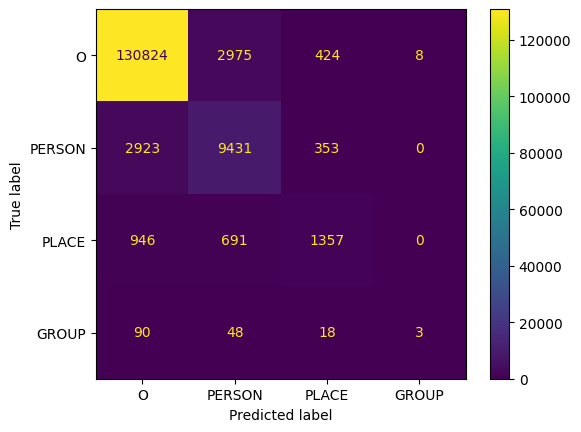

In [ ]:
labels = ['O', 'B-PERSON', 'B-PLACE', 'B-GROUP']
cm = confusion_matrix(true_labels, pred_labels, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['O', 'PERSON', 'PLACE', 'GROUP'])
disp.plot()

plt.show()

In [ ]:
pred_binary = []
for sent in range(len(true_labels)):
    for i in range(len(true_labels[sent])):
        if true_labels[sent][i] == pred_labels[sent][i]:
            pred_binary.append(1)
        else:
            pred_binary.append(0)

true_binary = [1] * len(pred_binary)

accuracy_score(true_binary, pred_binary)

0.9435275932600888

# BERT

In [ ]:
#определяем токенизатор
model_name = 'christinbeck/GHisBERT'
tokenizer = BertTokenizerFast.from_pretrained(model_name, model_max_length=512)

tokenizer_config.json:   0%|          | 0.00/176 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/219k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/589 [00:00<?, ?B/s]

In [ ]:
#создание пар токен-тег
test_tokens_dietrich, test_tags_dietrich = get_tokens_pairs(bio_tokens_dietrich, bio_tags_dietrich)

In [ ]:
classifier = pipeline("ner", model='/content/drive/MyDrive/4 курс/Диплом/models/GHisBERT-20epoch')

pred_labels = []
true_labels = []
for i in tqdm(range(len(bio_tokens_dietrich))):
    res = classifier(' '.join(bio_tokens_dietrich.iloc[i]))
    preds = []
    for word in res:
        preds.append(id2tag[int(word['entity'].split('_')[-1])])
    pred_labels.append(preds)

for i in tqdm(range(len(test_tokens_dietrich))):
    true_labels.append(test_tags_dietrich[i][1:-1])

res_dict = classification_report(true_labels, pred_labels, output_dict=True)

pd.DataFrame(res_dict).T

100%|██████████| 3915/3915 [00:00<00:00, 331216.09it/s]


,precision,recall,f1-score,support
GROUP,0.000000,0.000000,0.000000,118.0
PERSON,0.813456,0.429071,0.561807,11159.0
PLACE,0.665462,0.487519,0.562759,2644.0
micro avg,0.752383,0.436535,0.552505,13921.0
macro avg,0.492973,0.305530,0.374855,13921.0
weighted avg,0.778452,0.436535,0.557226,13921.0


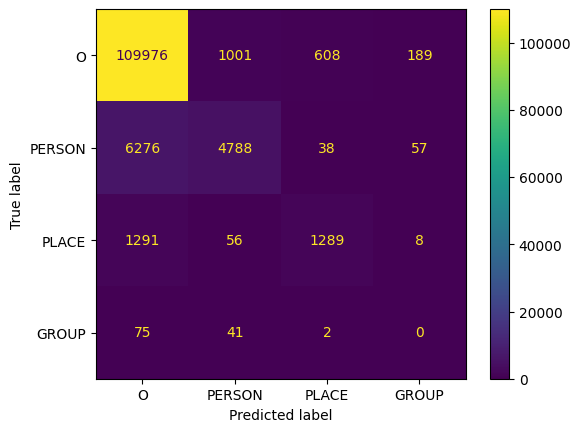

In [ ]:
labels = ['O', 'B-PERSON', 'B-PLACE', 'B-GROUP']
cm = confusion_matrix(true_labels, pred_labels, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['O', 'PERSON', 'PLACE', 'GROUP'])
disp.plot()

plt.show()

In [ ]:
pred_binary = []
for sent in range(len(true_labels)):
    for i in range(len(true_labels[sent])):
        if true_labels[sent][i] == pred_labels[sent][i]:
            pred_binary.append(1)
        else:
            pred_binary.append(0)

true_binary = [1] * len(pred_binary)

accuracy_score(true_binary, pred_binary)

0.923290504793349

# Flair

In [ ]:
model = SequenceTagger.load('/content/drive/MyDrive/4 курс/Диплом/models/flair-20epoch/best-model.pt')

pred_labels = []
true_labels = []
for i in tqdm(range(len(bio_tokens_dietrich))):
    sentence = Sentence(' '.join(bio_tokens_dietrich.iloc[i]))
    model.predict(sentence)
    entity_dict = {}
    for entity in sentence.get_spans('ner'):
        for token in entity:
            entity_dict[token.idx-1] = entity.get_label('ner').value
    preds = []
    for word_id in range(len(bio_tokens_dietrich.iloc[i])):
        if word_id in entity_dict.keys():
            preds.append('B-'+entity_dict[word_id])
        else:
            preds.append('O')
    pred_labels.append(preds)

for i in tqdm(range(len(bio_tokens_dietrich))):
    true_labels.append(bio_tags_dietrich.iloc[i])

res_dict = classification_report(true_labels, pred_labels, output_dict=True)

pd.DataFrame(res_dict).T

2024-05-25 09:37:03,295 SequenceTagger predicts: Dictionary with 15 tags: O, S-PERSON, B-PERSON, E-PERSON, I-PERSON, S-PLACE, B-PLACE, E-PLACE, I-PLACE, S-GROUP, B-GROUP, E-GROUP, I-GROUP, <START>, <STOP>


100%|██████████| 3915/3915 [00:00<00:00, 132127.71it/s]
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
GROUP,0.000000,0.000000,0.000000,52.0
PERSON,0.838311,0.680127,0.750980,4086.0
PLACE,0.906048,0.604032,0.724838,1389.0
micro avg,0.853101,0.654605,0.740786,5527.0
macro avg,0.581453,0.428053,0.491939,5527.0
weighted avg,0.847447,0.654605,0.737344,5527.0


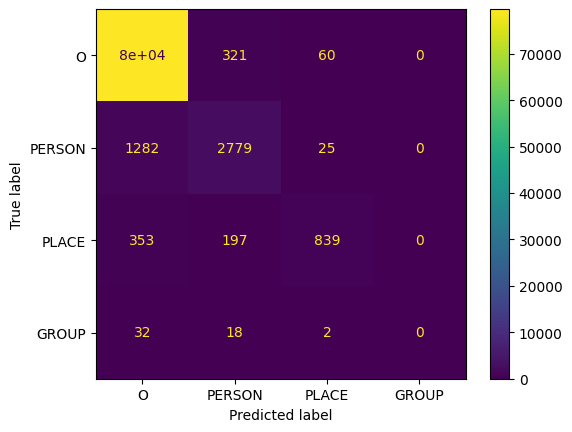

In [ ]:
labels = ['O', 'B-PERSON', 'B-PLACE', 'B-GROUP']
cm = confusion_matrix(true_labels, pred_labels, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['O', 'PERSON', 'PLACE', 'GROUP'])
disp.plot()

plt.show()

In [ ]:
pred_binary = []
for sent in range(len(true_labels)):
    for i in range(len(true_labels[sent])):
        if true_labels[sent][i] == pred_labels[sent][i]:
            pred_binary.append(1)
        else:
            pred_binary.append(0)

true_binary = [1] * len(pred_binary)

accuracy_score(true_binary, pred_binary)

0.9732216986096331